Make sure correct environment is used

In [1]:
# Install required packages into the same Python used by the notebook
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install tensorflow tensorflow-datasets matplotlib seaborn --quiet


Defaulting to user installation because normal site-packages is not writeable


Import libraries

In [5]:
import sys

# Install kernel for your Python version so Jupyter can use it
!{sys.executable} -m pip install --upgrade pip --quiet
!{sys.executable} -m pip install ipykernel tensorflow tensorflow-datasets matplotlib seaborn --quiet

# Link this environment to Jupyter
!{sys.executable} -m ipykernel install --user --name=task5_env --display-name "Python (Task 5)"


Installed kernelspec task5_env in C:\Users\admin\AppData\Roaming\jupyter\kernels\task5_env


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Load Food-101 dataset

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Make plots prettier
sns.set(style="whitegrid")


Preprocess

In [25]:
# Load dataset (Food-101)
(dataset_train, dataset_val), ds_info = tfds.load(
    'food101',
    split=['train[:5%]', 'validation[:5%]'],  # Use only 5% for speed
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

print(f"Loaded {num_classes} classes")
print(f"Example classes: {class_names[:10]}")


Loaded 101 classes
Example classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


Build CNN Model

In [11]:
IMG_SIZE = 128

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data = dataset_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = dataset_val.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


Train

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,405,349 (28.25 MB)

 Trainable params: 7,405,349 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

Plot Accuracy & Loss

In [15]:
history = model.fit(train_data, validation_data=val_data, epochs=3)


Epoch 1/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 57s 431ms/step - accuracy: 0.0114 - loss: 4.6358 - val_accuracy: 0.0095 - val_loss: 4.6134
Epoch 2/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 422ms/step - accuracy: 0.0206 - loss: 4.5844 - val_accuracy: 0.0206 - val_loss: 4.6019
Epoch 3/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 422ms/step - accuracy: 0.0905 - loss: 4.1997 - val_accuracy: 0.0127 - val_loss: 4.9315


Predict sample

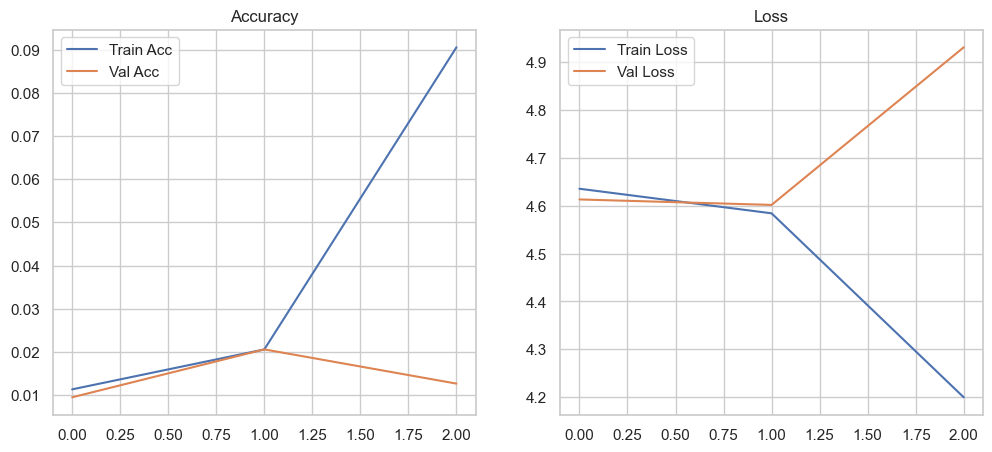

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


Predict sample

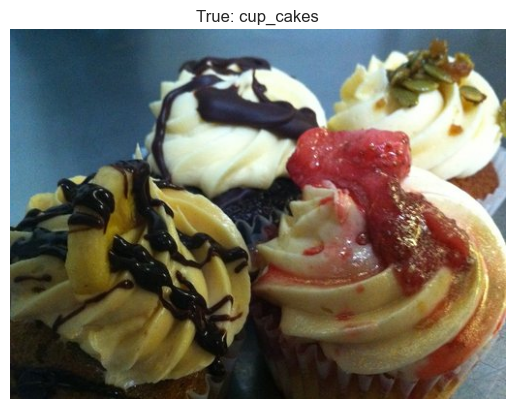

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Predicted: pork_chop


In [19]:
for image, label in dataset_val.take(1):
    plt.imshow(image)
    plt.title(f"True: {class_names[label.numpy()]}")
    plt.axis('off')
    plt.show()
    pred = model.predict(tf.expand_dims(tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, axis=0))
    print("Predicted:", class_names[tf.argmax(pred[0]).numpy()])


Key Insights 

conclusion